<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Telecomm EDA Challenge Lab

_Author: Alex Combs (NYC) _

---

Let's do some Exploratory Data Analysis (EDA)! As a data scientist, you often may find yourself given a data set you've never seen before, and asked to do a rapid analysis. This is today's goal.

# Prompt

You work for a telecommunications company. The company has been storing metadata about customer phone usage, as part of the regular course of business. Currently, this data is sitting in an unsecured database. The company doesn't want to pay to increase their database security, because they don't think there's really anything to be learned from the metadata.

They are under pressure from "right to privacy" organizations to beef up the database security. These organizations argue that you can learn a lot about a person from their cell phone metadata.

The telecom company wants to understand if this is true, and they want your help. They will give you one person's metadata for 2014 and want to see what you can learn from it.

Working in teams, create a report revealing everything you can about the person. Prepare a presentation, with slides, showcasing your findings.


# The Data

The [person's metadata](./datasets/metadata.csv) has the following fields:

| Field Name          | Description
| ---                 | ---
| **Cell Cgi**        | cell phone tower identifier
| **Cell Tower**      | cell phone tower location
| **Comm Identifier** |	de-identified recipient of communication
| **Comm Timedate String** | time of communication
| **Comm Type	Id**  | type of communication
| **Latitude**        | latitude of communication
| **Longitude**       | longitude of communication


# Hints

This is totally open-ended! If you're totally stumped -- and only if stumped -- should you look below for prompts. As a starting point, given that you have geo-locations, consider investigating ways to display this type of information (i.e. mapping functionality).

<font color='white'>
Well for starters, he's in Australia!

Ideas for things to look into:
- where does he work?
- where does he live?
- who does he contact most often?
- what hours does he work?
- did he move?
- did he go on holiday?  If so, where did he go?
- did he get a new phone?

Challenges:
- how does he get to work?
- where does his family live?
- if he went on holiday, can you find which flights he took?
- can you guess who some of his contacts are, based on the frequency, location, time and mode (phone/text) of communications?


If you're stuck on how to map the data, you can try "basemap" or "gmplot", or anything else you find online.
</font>

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
import seaborn as sns

!conda install folium --yes
!pip install folium

!pip install geopy

# pygmaps

!pip install gpxpy
import gpxpy.geo


df = pd.read_csv("../eda-telecomm_group_project-lab/datasets/metadata.csv")


Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - folium

Current channels:

  - https://repo.continuum.io/pkgs/main/osx-64
  - https://repo.continuum.io/pkgs/main/noarch
  - https://repo.continuum.io/pkgs/free/osx-64
  - https://repo.continuum.io/pkgs/free/noarch
  - https://repo.continuum.io/pkgs/r/osx-64
  - https://repo.continuum.io/pkgs/r/noarch
  - https://repo.continuum.io/pkgs/pro/osx-64
  - https://repo.continuum.io/pkgs/pro/noarch




,Cell Cgi,Cell Tower Location,Comm Identifier,Comm Timedate String,Comm Type,Latitude,Longitude
0,50501015388B9,REDFERN TE,f1a6836c0b7a3415a19a90fdd6f0ae18484d6d1e,4/1/14 9:40,Phone,-33.892933,151.202296
1,50501015388B9,REDFERN TE,62157ccf2910019ffd915b11fa037243b75c1624,4/1/14 9:42,Phone,-33.892933,151.202296
2,505010153111F,HAYMARKET #,c8f92bd0f4e6fb45ed7fce96fc831b283db2b642,4/1/14 13:13,Phone,-33.880329,151.205690
3,505010153111F,HAYMARKET #,f1a6836c0b7a3415a19a90fdd6f0ae18484d6d1e,4/1/14 13:13,Phone,-33.880329,151.205690
4,5.05E+106,HAYMARKET #,f1a6836c0b7a3415a19a90fdd6f0ae18484d6d1e,4/1/14 17:27,Phone,-33.880329,151.205690


In [128]:
# 
smsphone_mask = df[df['Comm Type'].isin(['SMS','Phone'])]

In [138]:
smsphone_commtype = smsphone_mask.groupby(["Comm Identifier"])['Comm Type'].value_counts().sort_values().tail(15)

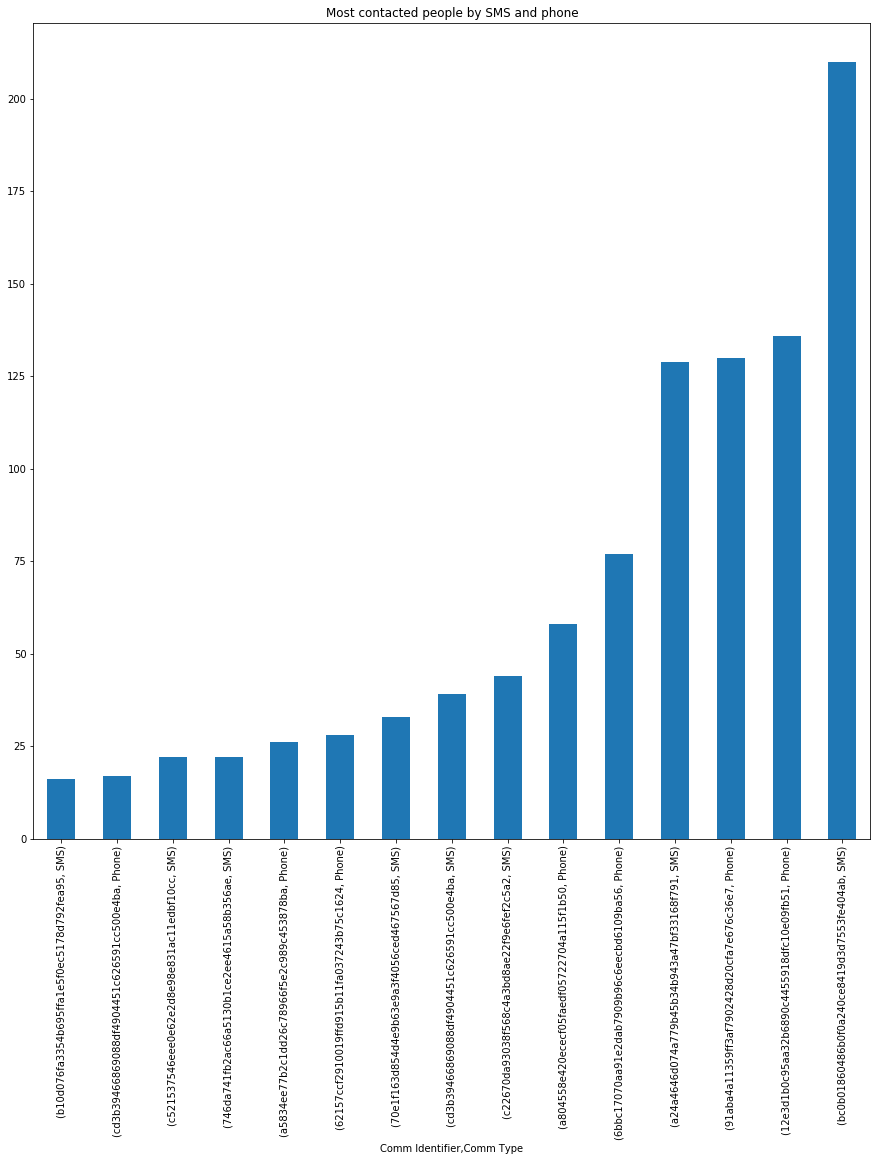

In [143]:
smsphone_mask = df[df['Comm Type'].isin(['SMS','Phone'])]
smsphone_commtype = smsphone_mask.groupby(["Comm Identifier"])['Comm Type'].value_counts().sort_values().tail(15)
smsphone_commtype.plot(kind = 'bar', figsize= (15,15),title = "Most contacted people by SMS and phone")

In [147]:
from dateutil import parser
df['Comm Timedate'] = df['Comm Timedate String'].apply(lambda x: parser.parse(x))
df['hour'] = df['Comm Timedate'].apply(lambda x: x.hour)

df.head()

,Cell Cgi,Cell Tower Location,Comm Identifier,Comm Timedate String,Comm Type,Latitude,Longitude,Comm Timedate,hour
0,50501015388B9,REDFERN TE,f1a6836c0b7a3415a19a90fdd6f0ae18484d6d1e,4/1/14 9:40,Phone,-33.892933,151.202296,2014-04-01 09:40:00,9
1,50501015388B9,REDFERN TE,62157ccf2910019ffd915b11fa037243b75c1624,4/1/14 9:42,Phone,-33.892933,151.202296,2014-04-01 09:42:00,9
2,505010153111F,HAYMARKET #,c8f92bd0f4e6fb45ed7fce96fc831b283db2b642,4/1/14 13:13,Phone,-33.880329,151.205690,2014-04-01 13:13:00,13
3,505010153111F,HAYMARKET #,f1a6836c0b7a3415a19a90fdd6f0ae18484d6d1e,4/1/14 13:13,Phone,-33.880329,151.205690,2014-04-01 13:13:00,13
4,5.05E+106,HAYMARKET #,f1a6836c0b7a3415a19a90fdd6f0ae18484d6d1e,4/1/14 17:27,Phone,-33.880329,151.205690,2014-04-01 17:27:00,17


In [174]:
hour = df[df['Comm Type'].isin(['SMS','Phone', 'Internet'])]
hour.count()

Cell Cgi                10476
Cell Tower Location     10476
Comm Identifier          1374
Comm Timedate String    10476
Comm Type               10476
Latitude                10476
Longitude               10476
Comm Timedate           10476
hour                    10476
dtype: int64

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10476 entries, 0 to 10475
Data columns (total 9 columns):
Cell Cgi                10476 non-null object
Cell Tower Location     10476 non-null object
Comm Identifier         1374 non-null object
Comm Timedate String    10476 non-null object
Comm Type               10476 non-null object
Latitude                10476 non-null float64
Longitude               10476 non-null float64
Comm Timedate           10476 non-null datetime64[ns]
hour                    10476 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 736.7+ KB


In [173]:
hour.pivot_table(index='hour',values='Comm Type')

DataError: No numeric types to aggregate

In [194]:
hour = df[df['Comm Type'].isin(['SMS','Phone', 'Internet'])]
usage_by_hour = hour.groupby(["hour", "Comm Type"])["hour"].agg('count')
use_by_hour = usage_by_hour.unstack()
use_by_hour.plot(kind = 'bar', figsize= (15,15),title = "Usage by hour")

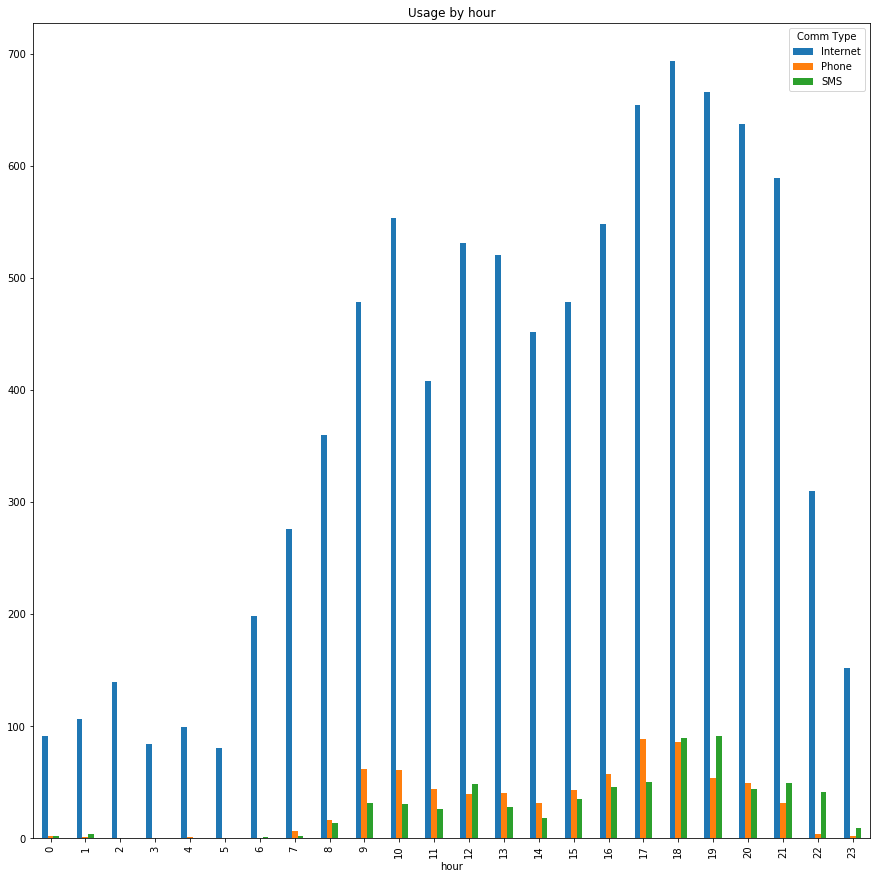

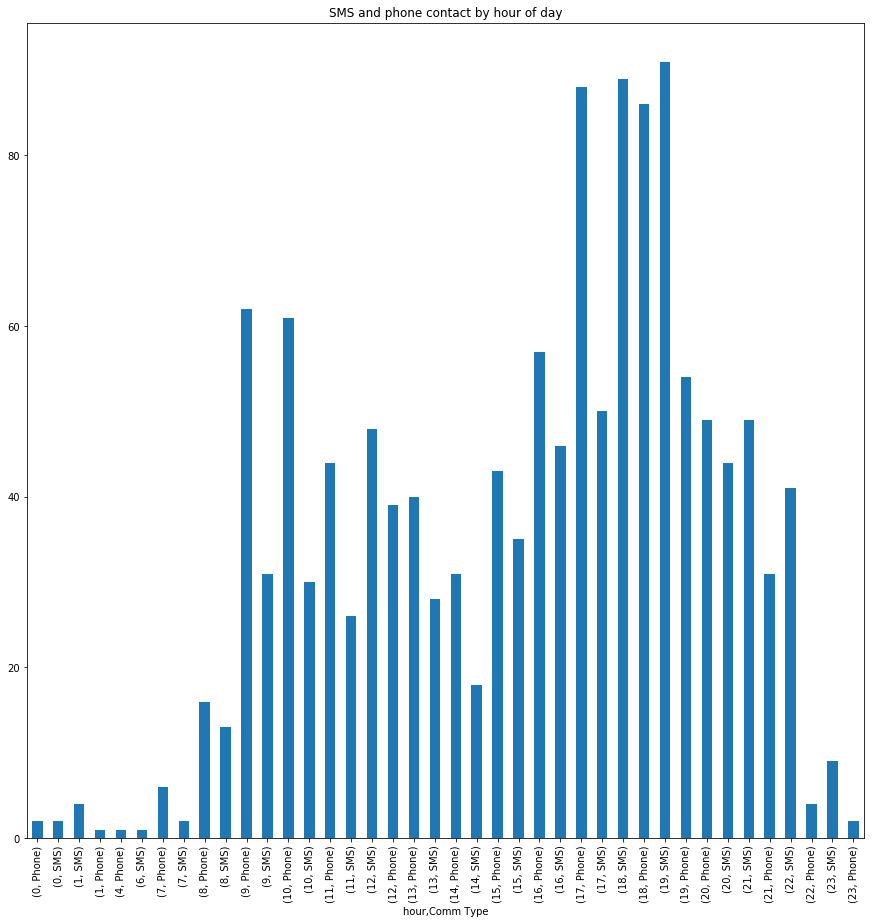

In [165]:
smsphone_byhour.plot(kind = 'bar', figsize= (15,15),title = "SMS and phone contact by hour of day")

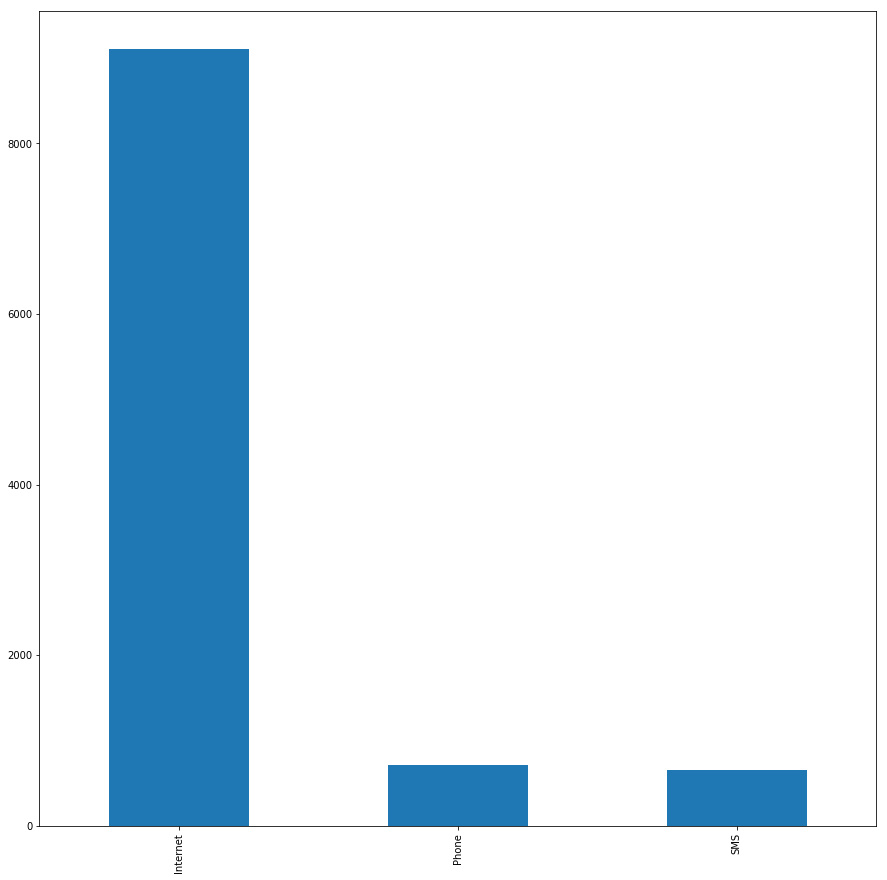

In [142]:
commtype = df["Comm Type"].value_counts()
commtype.plot(kind = 'bar', figsize= (15,15))

In [114]:
df.groupby(["Cell Tower Location"])['Comm Type'].value_counts().sort_values().tail(50)

Cell Tower Location                       Comm Type
KENT #                                    Internet       11
SURRY HILLS 418A ELIZABETH ST             SMS            11
HAYMARKET TE LEVEL 5 SRA BTS HOTEL        Internet       12
SUNDERLAND ST                             Phone          12
DEE WHY                                   Internet       12
MASCOT AIRPORT FAC3                       Internet       12
CREMORNE #                                Internet       12
COLLINS ST (HOBART)                       Internet       13
ULTIMO BULWARA RD                         Internet       13
SYDNEY DOMESTIC TERMINAL T2 - VIRGIN      Internet       15
FAIRLIGHT 137 SYDNEY RD                   SMS            16
SPIT BRIDGE                               Internet       18
THOONA                                    Internet       18
SEAFORTH                                  Internet       18
SYDNEY 505 GEORGE ST                      Internet       18
SURRY HILLS                               Intern

In [58]:
person_commtype =df.groupby(["Comm Identifier"])['Comm Type'].value_counts()
person_commtype.sort_values()

Comm Identifier                           Comm Type
018cad8a2f878aedb076fed31a884ce4660ba3f8  Phone          1
9039f13710c84d207864169cacc97ddc1b5accb1  SMS            1
8cf35d5b8a3c98ccfa54ed8df253822cb7b39c90  Phone          1
8a84ca2b5f3bd85c6e8d6381eee3036a8e5a334c  Phone          1
852715872cb9adf5424a385d189b83b5f88ecd73  SMS            1
832d39b1f31ad2ddd1720abdd4dacd365079e2db  Phone          1
81d04c5a17bdba7d504f90cf837a74f640a387cd  Phone          1
809b9fef422c854085624d5de2ac512944ca4902  Phone          1
f5411dda04b275b907e9de3518ff84f7117de909  Phone          1
9273651b8b7673b1cb73fbfd69a810ea30e07666  Phone          1
7cb96eadd3ff95e25406d24794027c443c0661c5  Phone          1
76410549febefdf637cd95e6608081a1e44f3bf7  Phone          1
7442b8b2c68f4ffea121be1750e81bc5334e3d24  Phone          1
73269cfd2741bca3d06ed0d3e0e5f325cf4efddb  Phone          1
7325eeeaf3601e7d67d601e7fbfd5282764c5c3a  Phone          1
6dad3704c00eb122d2f183ca612ef8990cc72bea  Phone          1
6d40